This example will perform character recognition through user input into the touch screen of an STM3240G-Evaluation board using the MNIST dataset.

In [1]:
#%tensorflow_version 2.x
#!apt-get install -y xxd
!pip install deap
#! pip uninstall -y tensorflow
#! pip install -q tf-nightly
#! pip install -q tensorflow-model-optimization
!pip install numpy


     |████████████████████████████████| 163kB 2.7MB/s 


Importing Tensorflow allows you to use its API to load the MNIST dataset. It should be noted that we need to use TF version <1.14 as this version includes the fully connected operation version 3 which is incompatible with the micro interpreters version 2.

In [2]:
import random

from deap import base
from deap import creator
from deap import tools
import tensorflow as tf
from tensorflow import keras

(images_train, labels_train), (images_test, labels_test) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


[5 0 4 ... 5 6 8]
3


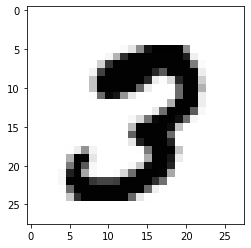

In [3]:
import matplotlib.pyplot as plt
test_index = 12345
print(labels_train)
print(labels_train[test_index])
plt.imshow(images_train[test_index], cmap='Greys')

The input of the neural network needs to know the input shape that it is going to be fed

In [4]:
input_shape = images_train.shape
print("{} images, each with shape of {} pixels x {} pixels".format(input_shape[0], input_shape[1], input_shape[2]))

60000 images, each with shape of 28 pixels x 28 pixels


The input shape for the model must be reshaped to 4D as the current shape does not show that each pixel is a 1D array where only the greyscale value (0-255) is stored. The input tensor's shape will be 3D as it will take a single-channel image. 

In [5]:
images_train = images_train.reshape(images_train.shape[0], images_train.shape[1], images_train.shape[2], 1)
images_test = images_test.reshape(images_test.shape[0], images_test.shape[1], images_test.shape[2], 1)
input_tensor_shape = (images_test.shape[1], images_test.shape[2], 1)
print("Input shape: {}".format(input_shape))

Input shape: (60000, 28, 28)


The greyscale values stores in the images' pixels are 8 bit values and need to be normalized into floats between 0-1.

In [6]:


images_train = images_train.astype('float32')
images_test = images_test.astype('float32')
print()
images_train /= 255
images_test /= 255

Model Configuration Data structure to  store in JSON file. Double-click (or enter) to edit

In [7]:
from enum import Enum, auto
import sys

class Conv2DArgs(Enum):
  'Args needed for creating Conv2DArgs layer, list not complete'
  FILTERS = auto()
  KERNEL_SIZE = auto()
  STRIDES = auto()
  INPUT_SIZE = auto()

class MaxPool2DArgs(Enum):
  'Args needed for creating MaxPool2D layer, list not complete'
  POOL_SIZE = auto()
  STRIDES = auto()

class ReshapeArgs(Enum):
  'Args needed for creating Reshape layer'
  TARGET_SHAPE = auto()

class DenseArgs(Enum):
  'Args needed for creating Dense layer, list not complete'
  UNITS = auto()
  ACTIVATION = auto()

class DropoutArgs(Enum):
  'Args needed for creating Dropout layer, list not complete'
  RATE = auto()

class ModelLayer:
  'Common layer properties'

  def __init__(self, name):
    self.name = name
    self.args = {}

class Conv2DLayer(ModelLayer):

  def __init__(self, filters, kernel_size, strides, input_size):
    super().__init__("Conv2D")
    self.args[Conv2DArgs.FILTERS.name] = filters
    self.args[Conv2DArgs.KERNEL_SIZE.name] = kernel_size
    self.args[Conv2DArgs.STRIDES.name] = strides
    self.args[Conv2DArgs.INPUT_SIZE.name] = input_size 

  def getkeraslayer(self):
    kernel_size=self.args.get(Conv2DArgs.KERNEL_SIZE.name)
    strides=self.args.get(Conv2DArgs.STRIDES.name)
    input_shape=self.args.get(Conv2DArgs.INPUT_SIZE.name)
    return keras.layers.Conv2D(
        self.args.get(Conv2DArgs.FILTERS.name), 
        kernel_size=self.args.get(Conv2DArgs.KERNEL_SIZE.name), 
        strides=self.args.get(Conv2DArgs.STRIDES.name), 
        input_shape=self.args.get(Conv2DArgs.INPUT_SIZE.name))

class MaxPool2DLayer(ModelLayer):

  def __init__(self, pool_size, strides):
    super().__init__("MaxPool2D")
    self.args[MaxPool2DArgs.POOL_SIZE.name] = pool_size
    self.args[MaxPool2DArgs.STRIDES.name] = strides 

  def getkeraslayer(self):
    return keras.layers.MaxPool2D(
        pool_size=self.args.get(MaxPool2DArgs.POOL_SIZE.name),
        strides=self.args.get(MaxPool2DArgs.STRIDES.name)
    )

class MaxPool3DLayer(MaxPool2DLayer):

  def __init__(self, pool_size, strides):
    super(MaxPool2DLayer, self).__init__("MaxPool3D")
    super().__init__(pool_size, strides)
    
  def getkeraslayer(self):
    return keras.layers.MaxPool3D(
        pool_size=self.args.get(MaxPool2DArgs.POOL_SIZE.name),
        strides=self.args.get(MaxPool2DArgs.STRIDES.name)
    )
  
class ReshapeLayer(ModelLayer):

  def __init__(self, target_shape):
    super().__init__("Reshape")
    self.args[ReshapeArgs.TARGET_SHAPE.name] = target_shape

  def getkeraslayer(self):
    target_shape = self.args.get(ReshapeArgs.TARGET_SHAPE.name)
    return keras.layers.Reshape(target_shape)

class DenseLayer(ModelLayer):

  def __init__(self, units, activation):
    super().__init__("Dense")
    self.args[DenseArgs.UNITS.name] = units
    self.args[DenseArgs.ACTIVATION.name] = activation

  def getkeraslayer(self):
    units = self.args.get(DenseArgs.UNITS.name)
    activation = self.args.get(DenseArgs.ACTIVATION.name)
    return keras.layers.Dense(units, activation=activation)

class FlattenLayer(ModelLayer):

  def __init__(self):
    super().__init__("Flatten")

  def getkeraslayer(self):
    return keras.layers.Flatten()

class Dropout(ModelLayer):

  def __init__(self, rate):
    super().__init__("Dropout")
    self.args[DropoutArgs.RATE.name] = rate
  
  def getkeraslayer(self):
    rate = self.args.get(DropoutArgs.RATE.name)
    return keras.layers.Dropout(rate)
  

For Model_Configuration1, the the convolutional NN that we 
will use to classify the input images taken from the touch screen will have the following layer structure

*  Conv2D
*  MaxPooling2D
*   Flatten
*   Dense
*   Dropout





The Conv2D layer extracts features from the input image using filters that slide across the input image. For eg. if we use 28 different filters to extract a large number of unique features that will then be used to classify each image in the later layers. Thus the output of this layer will have the shape (28, 28, 1, 28)

MaxPooling2D is used to reduce the output size of the convolutional layer by reducing for eg: each 2 x 2 unique chunk of the output down in to a singular value, this reducing the output's size by a factor of 4. This will reduce our (28, 28, 1, 28) tensor down to a (7, 7, 1, 28) tensor.

The Flatten layer then takes this 2D array (our image) and shapes it into a single dimension (1372).

The following Dense layer reduces the input 1372 values down into 128 classes, taking the first steps in classifying the image into on of the 10 output classes (0-9). This is done using the relu activation function.

The Dropout layer sets eg: 20% (if Drop out rate =0.2) of the tensor's values to 0 so as to reduce overfitting.

Finally the last Dense layer reduces the output value down to the 10 classes, each representing a digit between 0 and 9. This is done using the softmax activation function which makes the outputs a set of probabilities summing to 1.


Here, each individual is a list of dictionary, where each dictionary is a layer with keys as different attributes or parameters  of the layer  and values as the values of those parameters which are generated randomly on creation of a new individual or a new CNN architecture.
Upto this point no. of layers in a CNN architecture if fixed which indicates that individual size is same in the population.

In the creation of individual i.e a CNN architecture the Conv layer parameters are randomly generated and checked for validity conditions using some equations to validate CNN filter_size, padding and stride.

Further randomness need to applied on the parameters of other layers in the architecture like the pool size generation, No. of Activation units and Dropout rate.Also, sequence and number of layers in CNN need to changed randomly hile generating a new Individual.

In [10]:
# Modular Functions to generate Layers 

def filters():
  while True:
    n = random.randint(1, 20)
    if n%2 == 0:
        return n
def kernel_size():
  kernel_size=[1,3,5]
  return random.choice(kernel_size)


def Create_Conv():
    Conv_Layer={}
    Conv_Layer['name']='Conv2D'
    Conv_Layer['INPUT_SIZE']=[28,28,1]
    Conv_Layer['FILTERS']=filters() #check on usage F<=N
    kernel=kernel_size()
    Conv_Layer['KERNEL_SIZE']=[kernel,kernel]
    Conv_Layer['STRIDE']=(1,1)
    Conv_Layer['PADDING']=int((kernel_size()-1)/2)
    if(Conv_Layer['FILTERS']>= Conv_Layer['INPUT_SIZE'][0]):
      print(Conv_Layer['FILTERS'])
      print(Conv_Layer['INPUT_SIZE'][0])
      print('Invalid Conv Layer')
    else:
      print("valid Conv Layer")
      print(Conv_Layer)
    return Conv_Layer

def Create_Flatten():
    Flatten_Layer={}
    Flatten_Layer['name']='Flatten'
    print("Created Flatten Layer")
    return Flatten_Layer

def Create_Maxpool():
    Pool_Layer={}
    Pool_Layer['name']='Maxpool2D'
    Pool_Layer['POOL_SIZE']= [2, 2]
    print("Created Maxpool Layer")
    return Pool_Layer

def Create_Dense():
    Dense_Layer={}
    Dense_Layer['name']='Dense'
    Dense_Layer['UNITS']=128
    Dense_Layer['ACTIVATION']='relu'
    print("Created Dense Layer")
    return Dense_Layer

def Create_Output():
    Dense_Layer={}
    Dense_Layer['name']='Dense'
    Dense_Layer['UNITS']=10
    Dense_Layer['ACTIVATION']='softmax'
    print("Created Final Static Dense Layer")
    return Dense_Layer


def Create_Dropout():
    Dropout_Layer={}
    Dropout_Layer['name']='Dropout'
    Dropout_Layer['RATE']=0.2
    print("Created Dropout Layer")
    return Dropout_Layer


Here, the create() function takes at least two arguments, a name for the newly created class eg: "FitnessMulti" and a base class eg: "base.Fitness". Any subsequent argument becomes an attribute of the class. Here, weights are the attributes of our newly created Class "FItnessMulti". For Multi-Objective fitnesses the weights attribute must be a tuple where negative and positive signs indicates minimizing and maximizing the fitness respectively.

In [9]:
# creator is a class factory that can build new classes at run-time
# fitness function on Individual 
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, ))

On running the above cell the datatype FitnessMulti is added dynamically to the creator subpackage and we can access it directly as ‘creator.FitnessMulti’.

We need first to define our individual, strategy and fitness as datatypes using Create. The first argument gives the datatype name, the second gives the base class and from the third argument the attributes for the class will follow up.

The individual created will be a simple list containing each layer as a dictionary for eg: [{Layer1},{Layer2},{Layer3}...{No_of_Layers}] with a minimizing an objectives fitness attribute i.e RMSE. In order to produce this kind of individual, we need to create an Individual class, using the creator, that will inherit from the standard list type and have a fitness attribute.
 DEAP looks for fitness attribute when it wants to update the fitness value or read it, ex. fitness Multi as one of the argument is passed into the function.

In [11]:
creator.create("Individual", list, fitness=creator.FitnessMulti)
#print(creator.Individual)

<class 'deap.creator.Individual'>


A toolbox stores functions and their arguments.

In [12]:
toolbox = base.Toolbox()

The newly introduced register() method takes at least two arguments; an alias and a function assigned to this alias. Any subsequent argument is passed to the function when called. Thus, the preceding code creates two aliases in the toolbox; Layer_dict and Individual.

The first one redirects to the create_layer() function which returns different types of Layers each time when called. The second one is a shortcut to the initRepeat() function, fixing its container argument to the creator.Individual class, its func argument to the toolbox.Layer_dict() function, and its number of repetitions argument to No_of_layers to be created for each Individual.

Now, calling toolbox.individual() will call initRepeat() with the fixed arguments and return a complete creator.Individual composed of each layer as a dictionary with 'n' such dictionaries, where n=No_of_Layers  with a minimizing multi-objective fitness attribute.

Populations are much like individuals. Instead of being initialized with attributes, they are filled with individuals. The population is initialized using the toolbox and the initRepeat() function directly.

Calling toolbox.population() will readily return a complete population in a list, providing a number of times the repeat helper must be repeated as an argument of the population function. The following example produces a population with 6 individuals.

In [13]:
# function to create an individual with pre-defined no. of layers 
def create_Layer(no_layers):
  
  print("printing the no. of layers created")
  print(create_Layer.counter )
  if(create_Layer.counter%no_layers== 0):
    create_Layer.counter += 1
    return Create_Conv()
  if(create_Layer.counter%no_layers ==1):
    create_Layer.counter += 1
    return Create_Maxpool()
  if(create_Layer.counter%no_layers ==2):
    create_Layer.counter += 1
    return Create_Flatten()
  if(create_Layer.counter%no_layers ==3):
    create_Layer.counter += 1
    return Create_Dense()
  if(create_Layer.counter%no_layers ==4):
    create_Layer.counter += 1
    return Create_Dropout()
  if(create_Layer.counter%no_layers ==5):
    create_Layer.counter += 1
    return Create_Output()

In [14]:
print(dir(toolbox))

no_layers=6
create_Layer.counter=0

toolbox.register("Layer", create_Layer,no_layers)

toolbox.register("Individual", tools.initRepeat, creator.Individual,
                 toolbox.Layer,no_layers)
toolbox.register("population", tools.initRepeat, list, toolbox.Individual)

population=toolbox.population(n=6)


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'clone', 'decorate', 'map', 'register', 'unregister']
printing the no. of layers created
0
valid Conv Layer
{'name': 'Conv2D', 'INPUT_SIZE': [28, 28, 1], 'FILTERS': 14, 'KERNEL_SIZE': [3, 3], 'STRIDE': (1, 1), 'PADDING': 0}
printing the no. of layers created
1
Created Maxpool Layer
printing the no. of layers created
2
Created Flatten Layer
printing the no. of layers created
3
Created Dense Layer
printing the no. of layers created
4
Created Dropout Layer
printing the no. of layers created
5
Created Final Static Dense Layer
printing the no. of layers created
6
valid Conv Layer
{'name': 'Conv2D', 'INPUT_SIZE': [28, 28, 1], 'FILTERS': 14, 'KERNEL_SIZE

In [16]:

class Model:

  def __init__(self, individual, optimizer='adam', 
               loss='sparse_categorical_crossentropy', metrics=['accuracy']):
    print("enetered Model")
    print("printing individual:")
    print(individual)
    self.optimizer = optimizer
    self.loss = loss
    self.metrics = metrics
    self.layers = []
    for layer in individual: 
      #print("printing layer:")
      #print(layer)
      #print(len(individual))
      layer_no=len(individual) #population =[[{layer1_ind1},{layer2_ind1},{layer3_ind1},{layer4_ind1},{layer5_ind1}],[{layer1_ind2},{layer2_ind2},{layer3_ind2},{layer4_ind2},{layer5_ind2}}],[]]
      name=layer['name']
      if name == "Conv2D":
        print("entered conv2d")
        strides=layer['STRIDE']
        filters = layer["FILTERS"]
        kernel = layer["KERNEL_SIZE"]
        kernel_size = tuple(kernel)
        input = layer["INPUT_SIZE"]
        input_size = tuple(input)
        self.layers.append(Conv2DLayer(filters, kernel_size, strides, input_size))
        #print("Created {} layer with {} filters, {} kernel size, {} stride size and {} input size".format(
        #name, filters, kernel_size, strides, input_size
      #))
      elif name == "Maxpool2D" or name == "MaxPool3D":
        print("entered maxpool")
        pool_size = layer["POOL_SIZE"]
        strides = None
        if name == "Maxpool2D":
          self.layers.append(MaxPool2DLayer(pool_size, strides))
          #print("Created {} layer with {} pool size and {} stride size".format(
              #name, pool_size, strides
          #))
        else:
          self.layers.append(MaxPool3DLayer(pool_size, strides))
          #print("Created {} layer with {} pool size and {} stride size".format(
              #name, pool_size, strides
        #))
      elif name == "Reshape":
        print("entered reshape")
        arg=population[str(layer)]["args"]
        target_shape = layer["TARGET_SHAPE"]
        self.layers.append(ReshapeLayer(target_shape))
        #print(" Created {} layer with {} target shape".format(name, target_shape))
      elif name == "Dense":
        
        units = layer["UNITS"]
        if(units==10):
          print("entered output static")
        else:
          print("entered Dense1")
        activation = getattr(tf.nn, layer["ACTIVATION"])
        self.layers.append(DenseLayer(units, activation))
        #print("Created {} layer with {} units and {} activation".format(name, units, activation))
      elif name == "Flatten":
        print("entered flatten")
        self.layers.append(FlattenLayer())
        #print("Created {} layer".format(name))
      elif name == "Dropout": 
        print("entered Dropout")
        rate = layer["RATE"]
        self.layers.append(Dropout(rate))
        #print("Created {} layers with {} rate".format(name, rate))
      #print(self.layer)

  def gettfmodel(self):
    model = keras.Sequential()
    for layer in self.layers:
      print(layer)
      model.add(layer.getkeraslayer())
    model.compile(optimizer=self.optimizer, loss=self.loss, metrics=self.metrics)
    return model
 

In [17]:
#Model(ind)

NameError: ignored

In [18]:
from keras.utils.layer_utils import count_params
def evalCNN(population):
  print("entered evalCNN")
  print("printing the population received in evalCNN params")
  print(population)
  outparam={}
  test_model=Model(population)
  tf_model= test_model.gettfmodel()
  print("printing model in gettfmodel")
  print(tf_model)
  history = tf_model.fit(x=images_train,y=labels_train, epochs=1, batch_size=100)
  print(history)
  res = tf_model.evaluate(images_test, labels_test)
  Total_Params=count_params(tf_model.trainable_weights)+count_params(tf_model.non_trainable_weights)
  return res[0]       # Ensure overweighted bags are dominated

Using TensorFlow backend.


**Implementation of NSGA-II Algorithm (Deap)**

In [19]:
toolbox.register("evaluate", evalCNN)
toolbox.register("select", tools.selNSGA2)

In [20]:

# begin the evolution
# random.seed(64)

# instantiate a population
CXPB, MUTPB, NGEN = 0.0, 0.0, 10
for g in range(NGEN):
    print("-- Generation %i --" % g)

    # select the next generation individuals
    print("printing the population before it generates offspring")
    print(population)
    offspring = toolbox.select(population, len(population))
    print("offspring")
    print(offspring)
    # clone the selected individuals
    offspring = list(map(toolbox.clone, offspring))

    # # apply crossover and mutation on the offspring
    # for child1, child2 in zip(offspring[::2], offspring[1::2]):
    #     if random.random() < CXPB:
    #         toolbox.mate(child1, child2)
    #         del child1.fitness.values
    #         del child2.fitness.values

    # for mutant in offspring:
    #     if random.random() < MUTPB:
    #         toolbox.mutate(mutant)
    #         del mutant.fitness.values

    # evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    # fitnesses = map(toolbox.evaluate, invalid_ind)
    # for ind, fit in zip(invalid_ind, fitnesses):
    #     ind.fitness.values = fit

    # print("  Evaluated %i individuals" % len(invalid_ind))

    # evaluate the entire population
    print("printing offspring being passed to evalCNN as params")
    print(offspring)
    fitnesses= list(map(toolbox.evaluate, offspring))
    for ind, fit in zip(population, fitnesses):
      ind.fitness.values = fit

    print("  Evaluated %i individuals" % len(population))

    # the population is entirely replaced by the offspring
    population[:] = offspring

    # gather all the fitnesses in one list and print the stats
    fits = [ind.fitness.values[0] for ind in population]

    length = len(population)
    mean = sum(fits) / length
    sum2 = sum(x*x for x in fits)
    std = abs(sum2 / length - mean**2)**0.5
 #As there is no mating, the population doesn't improve
    print("  Min %s" % min(fits))
    print("  Max %s" % max(fits))
    print("  Avg %s" % mean)
    print("  Std %s" % std)

-- Generation 0 --
printing the population before it generates offspring
[[{'name': 'Conv2D', 'INPUT_SIZE': [28, 28, 1], 'FILTERS': 14, 'KERNEL_SIZE': [3, 3], 'STRIDE': (1, 1), 'PADDING': 0}, {'name': 'Maxpool2D', 'POOL_SIZE': [2, 2]}, {'name': 'Flatten'}, {'name': 'Dense', 'UNITS': 128, 'ACTIVATION': 'relu'}, {'name': 'Dropout', 'RATE': 0.2}, {'name': 'Dense', 'UNITS': 10, 'ACTIVATION': 'softmax'}], [{'name': 'Conv2D', 'INPUT_SIZE': [28, 28, 1], 'FILTERS': 14, 'KERNEL_SIZE': [1, 1], 'STRIDE': (1, 1), 'PADDING': 2}, {'name': 'Maxpool2D', 'POOL_SIZE': [2, 2]}, {'name': 'Flatten'}, {'name': 'Dense', 'UNITS': 128, 'ACTIVATION': 'relu'}, {'name': 'Dropout', 'RATE': 0.2}, {'name': 'Dense', 'UNITS': 10, 'ACTIVATION': 'softmax'}], [{'name': 'Conv2D', 'INPUT_SIZE': [28, 28, 1], 'FILTERS': 4, 'KERNEL_SIZE': [5, 5], 'STRIDE': (1, 1), 'PADDING': 0}, {'name': 'Maxpool2D', 'POOL_SIZE': [2, 2]}, {'name': 'Flatten'}, {'name': 'Dense', 'UNITS': 128, 'ACTIVATION': 'relu'}, {'name': 'Dropout', 'RATE': 0

TypeError: ignored